<a href="https://colab.research.google.com/github/1kaiser/test2023/blob/main/TestingVisualizingWeights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import pathlib
dir='/content/files'
urls = 'https://github.com/1kaiser/Snow-cover-area-estimation/releases/download/v1/imagesfolder.zip'
data_dir = tf.keras.utils.get_file(origin=urls,
                                   fname='s',
                                   cache_subdir= dir,
                                   archive_format='auto',
                                   untar=False,
                                   extract=True)
!rm -r {dir}/s
data_dir = pathlib.Path(data_dir)

1116364563/1116364563 [==============================] - 107s 0us/step


In [79]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os.path
import re

from osgeo import gdal

def tif2array(input_file, calc_gain=True):

    dataset = gdal.Open(input_file, gdal.GA_ReadOnly)
    image_datatype = dataset.GetRasterBand(1).DataType
    image = np.zeros((dataset.RasterYSize, dataset.RasterXSize, dataset.RasterCount), dtype=float)
   
    # Loop over all bands in dataset
    for b in range(dataset.RasterCount):
        # Remember, GDAL index is on 1, but Python is on 0 -- so we add 1 for our GDAL calls
        band = dataset.GetRasterBand(b + 1)
        # Read in the band's data into the third dimension of our array
        image[:, :, b] = band.ReadAsArray()
    return image, dataset


In [75]:
image_dir = r'/content/files/'

#############################################################################
prefix = "sur_refl_"
end = ["b01", "b02", "b03", "b04", "b05", "b06", "b07", "day_of_year", "qc_500m", "raz", "state_500m", "szen", "vzen"]
DayOY = "_doy\[0-9]+_aid0001"
fileExt = r'.tif'
expression_b1 = prefix+end[0]
expression_b2 = prefix+end[1]
expression_b3 = prefix+end[2]
expression_b4 = prefix+end[3]
expression_b5 = prefix+end[4]
expression_b6 = prefix+end[5]
expression_b7 = prefix+end[6]


imgs_list_b1 = [f for f in os.listdir(image_dir) if f.__contains__(expression_b1)]

imgs_list_b1.sort(reverse=True)       

In [76]:
from google.colab import output
temp_dir = r'/content/'

def ybatchedimages(images_path, image_list, batch_idx):
  images = []
  path = os.path.join(images_path, image_list[batch_idx])
  pathb2 = path.replace(expression_b1, expression_b2)
  pathb4 = path.replace(expression_b1, expression_b4)
  pathb6 = path.replace(expression_b1, expression_b6)

  #creating file NDSI
  !gdal_calc.py \
    --overwrite \
    --type=Float32 \
    --NoDataValue=0 \
    -A {pathb4} \
    --A_band 1 \
    -B {pathb6} \
    --B_band 1 \
    -C {pathb2} \
    --C_band 1 \
    --outfile={temp_dir}"BothCheck_result_final.tif" \
    --calc="(((A.astype(float) - B)/(A.astype(float) + B))>=0.4)*(C.astype(float)/10000>0.11)"

  pathout = temp_dir+str('BothCheck_result_final.tif')
  images.append(tif2array(pathout, 0)[0])

  !rm -r {temp_dir}"BothCheck_result_final.tif"
  output.clear()
  return images


import jax.numpy as jnp
def xbatchedimages(images_path, image_list, batch_idx):
  images = []
  path = os.path.join(images_path, image_list[batch_idx])
  v1 = tif2array(path.replace(expression_b1, expression_b1),0)[0]
  v2 = jnp.append(v1, tif2array(path.replace(expression_b1, expression_b2),0)[0] , axis =2)
  v3 = jnp.append(v2, tif2array(path.replace(expression_b1, expression_b3),0)[0] , axis =2)
  v4 = jnp.append(v3, tif2array(path.replace(expression_b1, expression_b4),0)[0] , axis =2)
  v5 = jnp.append(v4, tif2array(path.replace(expression_b1, expression_b5),0)[0] , axis =2)
  v6 = jnp.append(v5, tif2array(path.replace(expression_b1, expression_b6),0)[0] , axis =2)
  v7 = jnp.append(v6, tif2array(path.replace(expression_b1, expression_b7),0)[0] , axis =2)
  images.append(v7)
  w1 = tif2array(path.replace(expression_b1, expression_b1),0)[0]
  w2 = tif2array(path.replace(expression_b1, expression_b2),0)[0]
  w3 = tif2array(path.replace(expression_b1, expression_b3),0)[0]
  w4 = tif2array(path.replace(expression_b1, expression_b4),0)[0]
  w5 = tif2array(path.replace(expression_b1, expression_b5),0)[0]
  w6 = tif2array(path.replace(expression_b1, expression_b6),0)[0]
  w7 = tif2array(path.replace(expression_b1, expression_b7),0)[0]
  return images

import jax.random as random
import jax.numpy as jnp
batch_size = 1
no_of_batches = int(len(imgs_list_b1)/batch_size)
def data_stream(i, no_of_batches):
  return jnp.asarray(xbatchedimages(image_dir, imgs_list_b1, i)), jnp.asarray(ybatchedimages(image_dir, imgs_list_b1, i))

In [194]:
#✅
import jax
import jax.numpy as jnp

import cv2
from google.colab.patches import cv2_imshow
import numpy as np 


def batch_encoded(args):
    img_list = []
    for i in range(args.shape[0]):
        c = args[i]
        c = c.reshape(-1, c.shape[2])
        p = positional_encoding(c)
        img_list.append(p.reshape(args.shape[1],args.shape[2],p.shape[1]))
        x = jnp.array(img_list)
    return x

#✅
!python -m pip install -qq -U flax orbax
# Orbax needs to enable asyncio in a Colab environment.
!python -m pip install -qq nest_asyncio


import jax
import jax.numpy as jnp

import flax
import optax
from typing import Any

from jax import lax
import flax.linen as nn
from flax.training import train_state, common_utils

apply_positional_encoding = True # Apply posittional encoding to the input or not
ndl = 8 # num_dense_layers Number of dense layers in MLP
dlw = 256 # dense_layer_width Dimentionality of dense layers' output space 

##########################################<< MLP MODEL >>#########################################
class MLPModel(nn.Module):
    dtype: Any = jnp.float32
    precision: Any = lax.Precision.DEFAULT
    apply_positional_encoding: bool = apply_positional_encoding
    @nn.compact
    def __call__(self, input_points):
      x = batch_encoded(input_points) if self.apply_positional_encoding else input_points
      for i in range(ndl):
          x = nn.Dense(dlw,dtype=self.dtype,precision=self.precision)(x)
          x = nn.relu(x)
          x = jnp.concatenate([x, input_points], axis=-1) if i == 4 else x
      x = nn.Dense(1, dtype=self.dtype, precision=self.precision)(x)
      return x
##########################################<< MLP MODEL >>#########################################

#✅
!python -m pip install -q -U flax
import optax
from flax.training import train_state
import jax.numpy as jnp
import jax


def Create_train_state(r_key, model, shape, learning_rate ) -> train_state.TrainState:
    variables = model.init(r_key, jnp.ones(shape)) 
    optimizer = optax.adam(learning_rate) 
    return train_state.TrainState.create(
        apply_fn = model.apply,
        tx=optimizer,
        params=variables['params']
    )

learning_rate = 1e-4
model = MLPModel() # Instantiate the Model

In [200]:
b = data_stream(110, no_of_batches)[0]
# print(b)
print(b.shape)
print(jnp.max(b[1]))

params = np.array(b[0])
print(params[:,:,0])
  # plt.imshow([0] , cmap = 'magma' )
  # plt.colorbar()
plt.tight_layout() 
plt.show()


(1, 233, 454, 7)
13653.0
[[-28672. -28672. -28672. ... -28672. -28672. -28672.]
 [-28672. -28672. -28672. ... -28672. -28672. -28672.]
 [-28672. -28672. -28672. ... -28672. -28672. -28672.]
 ...
 [-28672. -28672. -28672. ... -28672. -28672. -28672.]
 [-28672. -28672. -28672. ... -28672. -28672. -28672.]
 [-28672. -28672. -28672. ... -28672. -28672. -28672.]]


<Figure size 432x288 with 0 Axes>

In [199]:
b = data_stream(100, no_of_batches)[0]
print(b.shape)

a1 = jax.vmap(lambda x: b[0] * 2.0 ** x)(jnp.arange(18))
print(a.shape)
a = plotter(a1)
print(a.shape)
b = plotter(b)
print(b.shape)

plt.tight_layout() 
plt.axis('off')
plt.imshow(np.array(a,  dtype=np.uint8) , cmap = 'magma' )

# plt.imshow(cv2.split(np.array(a[0].reshape((233, 454, a.shape[2])),  dtype=np.uint8))[0] , cmap = 'magma' )

# plt.colorbar()

(1, 233, 454, 7)
(9, 105782, 7)


InconclusiveDimensionOperation: ignored

(105782, 7)
(105782, 91)


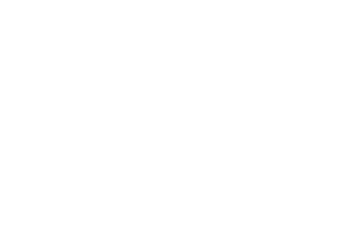

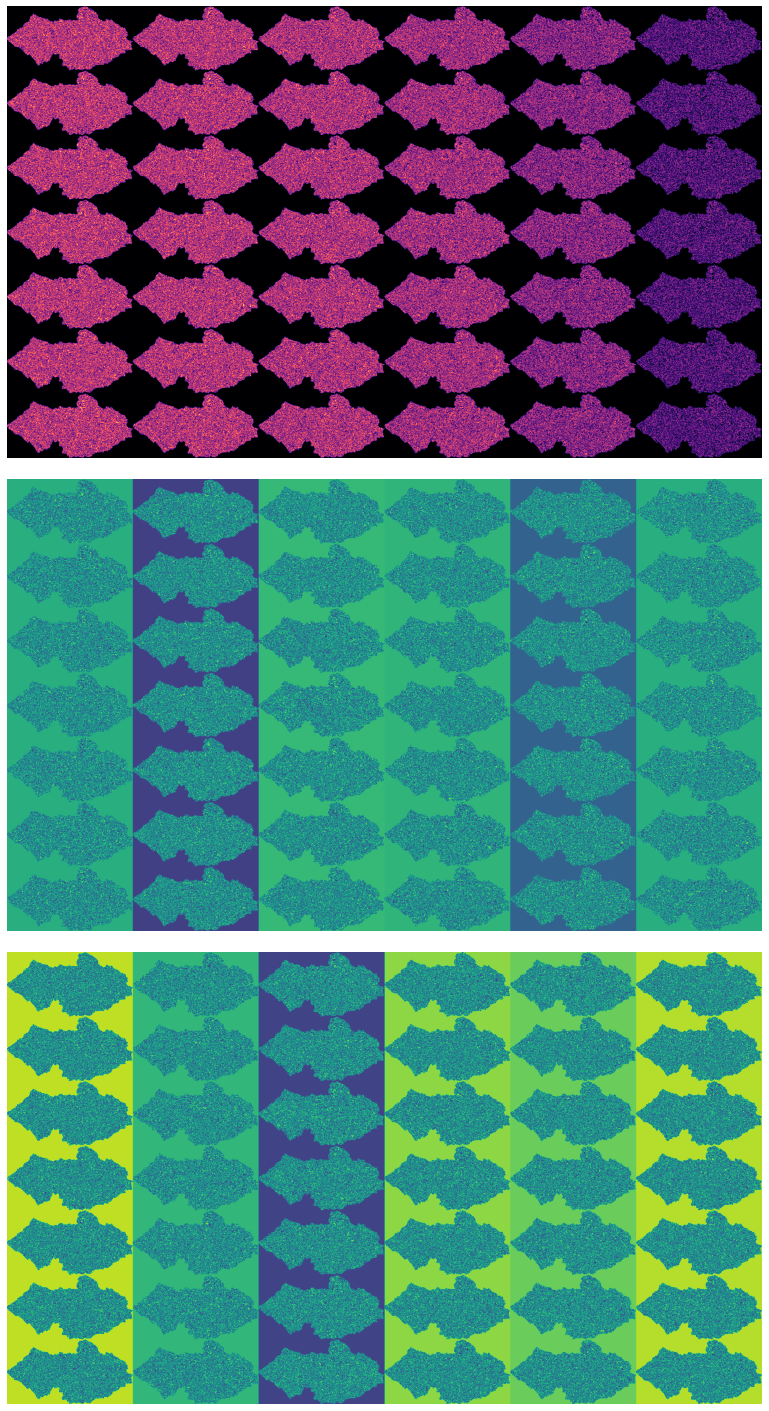

In [207]:
b = data_stream(100, no_of_batches)[0]
bx = data_stream(100, no_of_batches)[0]
b = b[0].reshape(b[0].shape[0]* b[0].shape[1], b[0].shape[2])
print(b.shape)
a1 = jax.vmap(lambda x: b * 2.0 ** x)(jnp.arange(6))
a = plotter(a1)
a = np.array(a*100,  dtype=np.uint8)

bb = jnp.stack([jnp.sin(a1), jnp.cos(a1)])
b1, b2 = jnp.stack([jnp.sin(a1), jnp.cos(a1)])[0], jnp.stack([jnp.sin(a1), jnp.cos(a1)])[1]
b1 = plotter(b1)
b1 = np.array(b1*100,  dtype=np.uint8)
b2 = plotter(b2)
b2 = np.array(b2*100,  dtype=np.uint8)

x = bb.swapaxes(0, 2).reshape([bx[0].shape[0]* bx[0].shape[1], -1])
x = jnp.concatenate([b, x], axis=-1)
print(x.shape)


plt.axis('off')
f, axarr = plt.subplots(3, sharex=True,figsize=(20,20))
plt.tight_layout() 
axarr[0].axis('off')
axarr[0].imshow(a, cmap = 'magma' )
axarr[1].axis('off')
axarr[1].imshow(b1)
axarr[2].axis('off')
axarr[2].imshow(b2)


In [208]:
x.shape

(105782, 91)

In [235]:
y = x
y.shape
print(y.shape)
y = jnp.concatenate([y,jnp.zeros((y.shape[0], 1))], axis=-1)
y = y.swapaxes(0,1)
y[0,:].reshape((233, 454)).shape

(105782, 91)


(233, 454)

In [214]:

y = x

for i in range(y.shape[1]):
  for j in range(int(y.shape[1]/2)+1):
    if (j==0):
      a1 = y[j]
    else:
      a1 = np.append(a1, y[j], 0)

  if (i==0):
    b1 = a1
  else:
    b1 = np.append(b1, a1, 1)

AxisError: ignored

In [190]:
positional_encoding_dims = 6  # Number of positional encodings applied
import matplotlib.pyplot as plt

def positional_encoding(args):
    image_height_x_image_width, cha = args.shape
    print(args.shape)
    inputs_freq = jax.vmap(lambda x: args * 2.0 ** x)(jnp.arange(positional_encoding_dims))
    a = plotter(inputs_freq)
    a = np.array(a*100,  dtype=np.uint8)

    x = jnp.stack([jnp.sin(inputs_freq), jnp.cos(inputs_freq)])
    b1, b2 = x[0], x[1]
    b1 = plotter(b1)
    b1 = np.array(b1*100,  dtype=np.uint8)
    b2 = plotter(b2)
    b2 = np.array(b2*100,  dtype=np.uint8)

    x = x.swapaxes(0, 2).reshape([image_height_x_image_width, -1])
    x = jnp.concatenate([args, x], axis=-1)

    plt.axis('off')
    f, axarr = plt.subplots(3, sharex=True,figsize=(20, 20))
    plt.tight_layout() 
    axarr[0].axis('off')
    axarr[0].imshow(a, cmap = 'magma' )
    axarr[1].axis('off')
    axarr[1].imshow(b1)
    axarr[2].axis('off')
    axarr[2].imshow(b2)

    plt.tight_layout() 
    plt.axis('off')
    plt.show()

    return x


**plotting**

In [191]:
import matplotlib.pyplot as plt
import numpy as np

def plotter(a):
  channels = a.shape[2]
  a1 = []
  for i in range(a.shape[0]):
    xxx = cv2.split(np.array(a[i].reshape((233, 454, channels))))
    # print(xxx[i].shape)
    for j in range(len(xxx)):
      if (j==0):
        a1 = xxx[j]
      else:
        a1 = np.append(a1, xxx[j], 0)

    if (i==0):
      b1 = a1
    else:
      b1 = np.append(b1, a1, 1)
  return b1





#test

In [185]:
#cpu serial
import jax

def train_step(state: train_state.TrainState, batch: jnp.asarray, rng):
    image, label = batch  
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, image);
        loss =  image_difference_loss(logits, label);
        return loss, logits

    gradient_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (_, logits), grads = gradient_fn(state.params)
    new_state = state.apply_gradients(grads=grads)
    logs = compute_metrics(logits=logits, labels=label)
    return new_state, logs

import jax
@jax.jit
def eval_step(state, image):
    logits = state.apply_fn({'params': state.params}, image)
    return compute_metrics(logits=logits, labels=image)


#serial
def image_difference_loss(logits, labels):
    loss =  0.5 * jnp.mean((logits - labels) ** 2) 
    return loss
    
def compute_metrics(*, logits, labels):
  loss = image_difference_loss(logits, labels)
  metrics = {
      'loss': loss,     #LOSS
      'logits': logits, #PREDICTED IMAGE
      'labels': labels  #ACTUAL IMAGE
  }
  return metrics

import cv2
from google.colab.patches import cv2_imshow
import numpy as np 

def show_image(pimage, oimage, newsize):
  L1 = pimage[0]
  predicted_image = np.array(pimage[0]*255,  dtype=np.uint8).reshape(newsize) # This would be your image array
  original_image = np.array(oimage[0]*255,  dtype=np.uint8).reshape(newsize) # This would be your image array
  a = cv2.vconcat([predicted_image, original_image])

  # for i in range(0,pimage.shape[0]):
  #   predicted_image = np.array(pimage[i]*255,  dtype=np.uint8).reshape(newsize)
  #   original_image = np.array(oimage[i]*255,  dtype=np.uint8).reshape(newsize) # This would be your image array
 
  #   a = cv2.hconcat([a, cv2.vconcat([predicted_image, original_image]))
  cv2_imshow(a)

In [195]:
#@title # **👠HIGH HEELS RUN >>>>>>>>>>>** { vertical-output: true }
newsize = (233, 454) #(260, 260) # /.... 233 * 454

import jax
from jax import random
from tqdm import tqdm
import re
from google.colab import output
import orbax.checkpoint as orbax
from flax.training import checkpoints

import optax
import nest_asyncio
nest_asyncio.apply()

rng = jax.random.PRNGKey(0)
CKPT_DIR = 'ckpts'

######################<<<< initiating train state
count = 0
if count == 0 :
  batches = data_stream(1, no_of_batches)
  BATCH, H, W, Channels = batches[0].shape
  state = Create_train_state( rng, model, (BATCH, H, W, Channels ), learning_rate ) 
  count = 1
#✅✅🔻 state = flax.jax_utils.replicate(state)  # FLAX will replicate the state to every device so that updating can be made easy

###################### 
checkpoint_available = 0
pattern = re.compile("checkpoint_\d+")   # to search for "checkpoint_*munerical value*" numerical value of any length is denoted by regular expression "\d+"
dir = "/content/ckpts/"
isFile = os.path.isdir(dir)
if isFile:
  for filepath in os.listdir(dir):
      if pattern.match(filepath):
          checkpoint_available = 1

total_epochs = 150
for epochs in tqdm(range(total_epochs)):  

  if checkpoint_available:
    state = checkpoints.restore_checkpoint(ckpt_dir=CKPT_DIR, target=state)
    checkpoint_available = 0 # << Flag updated >>> to stop loading the same checkpoint in the next iteration then remove the checkpoint directory
    !rm -r {dir}


  for Aimage in tqdm(range(no_of_batches-5)):
    input_data = data_stream(Aimage, no_of_batches)
    state, metrics = train_step(state, input_data, rng)
    show_image(metrics['logits'], metrics['labels'], newsize)

    # output.clear()
    print("loss: ",metrics['loss']," <<< ") # naming of the checkpoint is "checkpoint_*"  where "*" => value of the steps variable, i.e. 'epochs'
    # if (Aimage == total_epochs-1) :
    #   VisualizeKernel(state.params, epochs)

  orbax_checkpointer = orbax.Checkpointer(orbax.PyTreeCheckpointHandler())
  checkpoints.save_checkpoint(ckpt_dir=CKPT_DIR, target=state, step=epochs, prefix='checkpoint_', keep=1, overwrite=False, orbax_checkpointer=orbax_checkpointer)
  # restored_state = checkpoints.restore_checkpoint(ckpt_dir=CKPT_DIR, target=state) # using to get the checkpoint loaded , it can be latest one , or if already available as checkpoint in the "CKPT_DIR" directory then take the file from directory then save in >> restored_checkpoints
  ##################################################



(105782, 7)


  0%|          | 0/150 [00:35<?, ?it/s]


KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

data1 = np.random.random([6, 50])

colors1 = ['C{}'.format(i) for i in range(6)]

lineoffsets1 = [-15, -3, 1, -10, 6, 10]
linelengths1 = [5, 2, 1, 1, 3, 1.5]

plt.eventplot(data1, colors=colors1, lineoffsets=lineoffsets1,
                    linelengths=linelengths1)
plt.title('Event Plot')
plt.xlabel('Time(s)')
plt.ylabel('Signal')